In [1]:
# Used in the notebook
import qiskit
import scipy.linalg as sl # eigh function for generalized eigenvalue problem
from numpy.random import Generator, PCG64
import time
from datetime import timedelta
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute 
from qiskit_nature.circuit.library import HartreeFock
from qiskit.providers.aer import AerSimulator,QasmSimulator


from qugcm import *
from example_molecules import *
qiskit.__qiskit_version__

{'qiskit-terra': '0.22.2', 'qiskit-aer': '0.11.1', 'qiskit-ignis': '0.7.1', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.39.2', 'qiskit-nature': '0.4.5', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': '0.6.0'}

## Select/Input molecule information
Information of linear H4 and almost-square H4 are saved in `experiment_molecules.py` already

In [2]:
#--------- Inputs ---------#
data_folder = 'Data/' # <-- where to save the data if required
## Molecule parameters
tested_molecule = H4S # <-- Change here for H4L, and H4S (Linear H4, Almost square H4)
## Obtain the configuration of Basis (in Qiskit conversion)
basis_config_qis = H4_ALT_BASIS_CONFIG_QIS # <-- change according to "tested_molecule"
#--------------------------#
## Obtain information based on above inputs
total_energy_wc_repulsion = tested_molecule.total_wcrep
HF_energy_wc_repulsion_energy = tested_molecule.HF_wcrep
num_spin_orbitals = tested_molecule.norb
num_particles = tested_molecule.nptc
MAPPING = tested_molecule.mapping
qubit_op = tested_molecule.ham_op
## Use Hartree Fock as initial state
init_state = HartreeFock(num_spin_orbitals=num_spin_orbitals, 
                         num_particles=num_particles,
                         qubit_converter=QUBIT_CONVERTER)
## Check lowest eigenvalues using numpy if necessary
# w_ham,v_ham = nl.eigh(qubit_op.to_matrix())
# print("True lowest eigenvalue: {:.4f}, After JW transform: {.4f}".format(total_energy_wc_repulsion, 
#                                                                                w_ham[0]))

## Setup the simulator, choose parameter values (t's) and interested basis

In [3]:
seed = 1976141
num_shots = 1 # not required for AerSimulator because it always have infinite number of shots
backend = AerSimulator(method='statevector') # NO GPU acceleration on Windows, also seems not on WSL2

## Generate t's
rng = Generator(PCG64(seed))
ts = rng.random(6)*100 # only non-composite
ts = np.append([1], ts) # Inserting 1 for R0
print('t\'s (t1 to the end):', ts[1:])

t's (t1 to the end): [25.96260158 69.6794953  18.18546335 75.88296988 59.46456129 79.74292489]


In [4]:
## H4
basis_interested = ['R0',
                    '+R1', '-R1', 
                    '+R2', '-R2', 
                    '+R3', '-R3', 
                    '+R4', '-R4',
                    '+R3+R5', '+R4+R6',
                   '+R2+R1', '+R2-R1', '-R2+R1', '-R2-R1'] # for computation inputs, all basis that of interest, characters are capitalized
basis_displayed = ['R0',
                    '+R1', '-R1', '+R2', '-R2', 
                    '+R3', '-R3', '+R4', '-R4','R7','R8',
                   '+R2+R1', '+R2-R1', '-R2+R1', '-R2-R1'] # for displaying the matrix, R5 to R8 has no sign

num_of_basis = len(basis_interested)
print("Number of Basis: {:d}".format(num_of_basis))

Number of Basis: 15


## Compute S and H, then solved the generalized eigenvalue problem

First, try to find the expectation (i.e., every matrix entry) classically.

In [5]:
print("Classical")
start_time = time.time()
S_class,H_class = est_SH_class(qubit_op,
                    basis_interested, ts, 
                    basis_config_qis,
                    init_state, 
                    num_spin_orbitals, num_particles, print_progress=False)

end_time = time.time()
time_elp = end_time - start_time
print("Time Elapsed (hh:mm:ss): ", timedelta(seconds=time_elp))
w_s,v_s = np.linalg.eigh(S_class)
print("First 3 lowest eigenvalue of S: {:.4f}, {:.4f}, {:.4f}".format(w_s[0], w_s[1], w_s[2]))

Classical
Time Elapsed (hh:mm:ss):  0:03:30.629908
First 3 lowest eigenvalue of S: 0.0200, 0.0229, 0.0454


In [9]:
w_class,v_class = sl.eigh(H_class, S_class)
print("Lowest eigenvalue of the generalize eigenvalue problem: {:.6f},".format(w_class[0]))
print("Thoertical result: {:.6f}".format(total_energy_wc_repulsion))
print("Error: {:.6e}".format(np.abs(total_energy_wc_repulsion - w_class[0])))

Lowest eigenvalue of the generalize eigenvalue problem: -4.629237,
Thoertical result: -4.629382
Error: 1.459198e-04


For the computation in simulator, use a smaller set of basis instead (for **demo purpose**).

In [14]:
## H4
basis_interested = ['R0','+R1']
basis_displayed = basis_interested

Simulator
Time Elapsed (hh:mm:ss):  0:02:09.907916
First 2 lowest eigenvalue of S: 0.5444, 1.4556


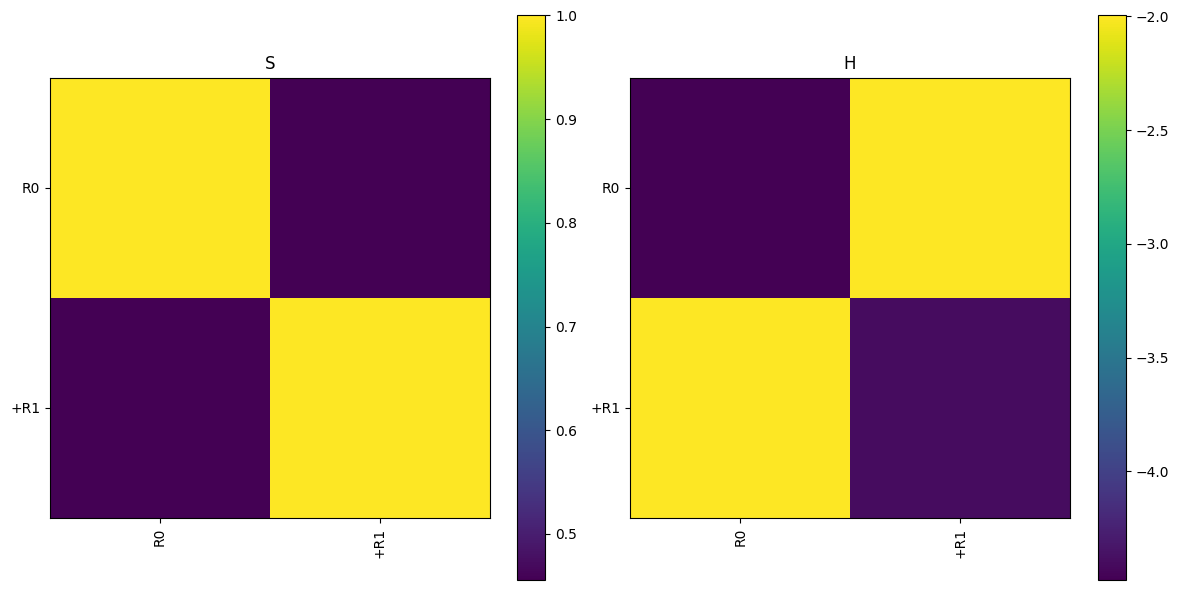

In [20]:
print('Simulator')
## Computing matrices for generalized eigenvalue problem Hv = ESv
start_time = time.time()
S,H = est_SH_qwc(qubit_op,
                basis_interested, ts, 
                basis_config_qis,
                init_state, 
                num_spin_orbitals, num_particles,
                backend,num_shots=num_shots, opt_level=1, seed=seed)
end_time = time.time()
time_elp = end_time - start_time
print("Time Elapsed (hh:mm:ss): ", timedelta(seconds=time_elp))
print("Time Elapsed (hh:mm:ss):  0:02:09.907916")

## Verify singularity of S
w_s,v_s = np.linalg.eigh(S)
print("First 2 lowest eigenvalue of S: {:.4f}, {:.4f}".format(w_s[0], w_s[1]))
plot_sh(S.real, H.real, basis_displayed, save_name=None, exp_name='')

In [21]:
## Solve generalize eigenvalue problem
w_nh, v_nh = sl.eigh(H, S)
print("Lowest eigenvalue of the generalize eigenvalue problem: {:.6f},".format(w_nh[0]))
print("Thoertical result: {:.6f}".format(total_energy_wc_repulsion))
print("Error: {:.6e}".format(np.abs(total_energy_wc_repulsion - w_nh[0])))

Lowest eigenvalue of the generalize eigenvalue problem: -4.506519,
Thoertical result: -4.629382
Error: 1.228636e-01


With 15 basis, we can obtain the error described in the paper.

In [22]:
# A simple check: if ||Hv - ESv|| = 0 for all E and v
for i in range(S.shape[0]):
    print(np.linalg.norm(H.dot(v_nh[:,i]) - w_nh[i]*S.dot(v_nh[:,i])))

9.694605782931786e-16
8.881784197061476e-16
